In [1]:
import numpy as np
#####################################
import torch
import torch.nn as nn
#import torch.nn.functional as F
from torch import optim, autograd
#####################################
from matplotlib import pyplot as plt

In [2]:
def random_dom_points(n=4096,d=1):
    x = torch.rand(n,d)
    x.requires_grad = True
    y = torch.rand(n,d)
    y.requires_grad = True
    return x,y
def random_bc_points(n=64):
    n_ = int(n/4)
    x1 = torch.rand(n_,1)
    y1 = torch.zeros(n_,1)
    #
    x2 = torch.ones(n_,1)
    y2 = torch.rand(n_,1)
    #
    x3 = torch.rand(n_,1)
    y3 = torch.ones(n_,1)
    #
    x4 = torch.zeros(n_,1)
    y4 = torch.rand(n_,1)
    x = torch.cat((x1,x2,x3,x4),0)
    y = torch.cat((y1,y2,y3,y4),0)
    x.requires_grad = True
    y.requires_grad = True
    return x,y

In [3]:
def f(x,y):
    
    aux = 2*(np.pi)**2*torch.sin(np.pi*x)*torch.sin(np.pi*y)
    return aux.view(-1,1)

In [4]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Is cuda available?',torch.cuda.is_available())
print('Used device:',device)

Is cuda available? False
Used device: cpu


In [5]:
epochs = 50000 #50000

in_N = 1
m = 10
out_N = 1

In [6]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, act=nn.Sigmoid(), device=torch.device("cpu")):
        super(Model, self).__init__()

        self.layers = nn.ModuleList()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]).to(device))

        self.activation = act.to(device)
        self.device = device

    def forward(self, x, y):
        inputs = torch.cat([x, y], axis=1)  # Concatenate x and t
        for layer in self.layers[:-1]:
            inputs = self.activation(layer(inputs))
        output = self.layers[-1](inputs)
        return output

In [7]:
model = Model(2,[10,10,20,20,20,10],1)

In [8]:
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
  (activation): Sigmoid()
)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=3e-3)

$$\mathcal{L}(u) = \int_{\Omega} |\nabla u|^2 - fu\,dx + \alpha \int_{\partial \Omega} \left(u - bc\right)^2\,dS$$

In [10]:
best_loss, best_epoch = 1000, 0
loss_vector = []
for epoch in range(epochs+1):
    # Clear previous gradient computation
    optimizer.zero_grad()
    # Random interior points
    x,y = random_dom_points()
    u   = model(x,y)
    # Gradient computation 
    u_x = autograd.grad(outputs=u, 
                          inputs=x,
                          create_graph=True, 
                          grad_outputs=torch.ones_like(u)
                         )[0]
    u_y = autograd.grad(outputs=u, 
                          inputs=y,
                          create_graph=True, 
                          grad_outputs=torch.ones_like(u)
                         )[0]
    # Loss function (1st component)
    loss1 = torch.mean(0.5*(u_x**2 + u_y**2) - f(x,y)*u)
    # Loss function (2nd component)
    x_bc,y_bc = random_bc_points()
    u_bc = model(x_bc,y_bc)
    loss2 = torch.mean((u_bc - 0.)**2)
    # Loss function
    loss = loss1 + 500*loss2    
    # Backpropagation
    loss.backward()
    # ANN's weights update
    optimizer.step()
    #
    loss_vector.append(loss.item())
    #
    if epoch % 5000 == 0:
        print('epoch:', epoch, 
              '\n loss      :', loss.item(), 
              '\n loss int  :', (loss1).item(), 
              '\n loss bound:', (loss2).item())
        if epoch > int(4 * epochs / 5):
            if torch.abs(loss) < best_loss:
                best_loss = torch.abs(loss).item()
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_approx.mdl')
print('best epoch:', best_epoch, 'best loss:', best_loss)
#loss      : -2.3757529258728027 
#loss int  : -2.3814682960510254 
#loss bound: 1.143070767284371e-05

epoch: 0 
 loss      : 23.32973289489746 
 loss int  : 1.6536794900894165 
 loss bound: 0.04335210844874382
epoch: 5000 
 loss      : -2.4823617935180664 
 loss int  : -2.59517240524292 
 loss bound: 0.00022562115918844938
epoch: 10000 
 loss      : -2.5070865154266357 
 loss int  : -2.59185528755188 
 loss bound: 0.00016953762678895146
epoch: 15000 
 loss      : -2.477992057800293 
 loss int  : -2.553969383239746 
 loss bound: 0.0001519546058261767
epoch: 20000 
 loss      : -2.400668144226074 
 loss int  : -2.4423813819885254 
 loss bound: 8.342643559444696e-05
epoch: 25000 
 loss      : -2.5741279125213623 
 loss int  : -2.593804359436035 
 loss bound: 3.9352948078885674e-05
epoch: 30000 
 loss      : -2.518113851547241 
 loss int  : -2.5849692821502686 
 loss bound: 0.00013371085515245795
epoch: 35000 
 loss      : -2.4747231006622314 
 loss int  : -2.5047783851623535 
 loss bound: 6.011068035149947e-05
epoch: 40000 
 loss      : -2.5701873302459717 
 loss int  : -2.618217706680298

In [11]:
torch.save(model.state_dict(), 'best_approx_2D_v2.mdl')

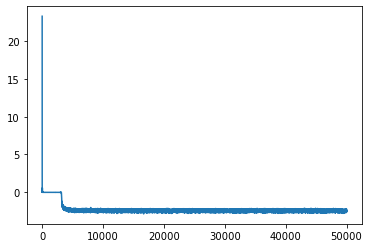

In [12]:
plt.plot(loss_vector)

In [ ]:
#model.load_state_dict(torch.load('best_approx_2D.mdl'))

In [13]:
with torch.no_grad():
    x1 = torch.linspace(0.,1,100)
    x1 = x1.flatten()[:, None]
    x2 = 0.8*torch.ones_like(x1)    
    y_hat = model(x1,x2)
    y_real = torch.sin(np.pi*x1)*torch.sin(np.pi*x2)

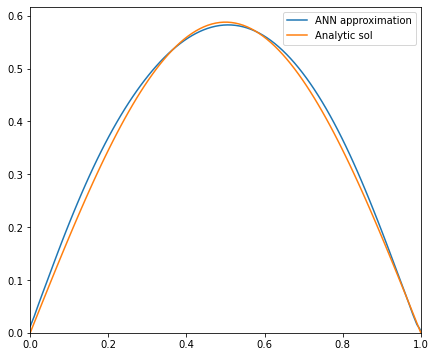

In [14]:
plt.figure(figsize=(7,6))
plt.plot(x1,y_hat,label='ANN approximation')
plt.plot(x1,y_real, label='Analytic sol')
#
plt.xlim(0,1)
plt.ylim(0,None)
#
plt.legend()